# Dimensionality Reduction: PCA (linear) and UMAP (non-linear)

We work on a curated, cleaned CPT dataset prepared in this repo. By default, we load the preprocessed, numeric features-only table at `data/model_ready/cpt_features.csv` and use it for unsupervised embeddings (PCA/UMAP). The corresponding labels (Oberhollenzer 1–7 classes) are available in `data/model_ready/cpt_dataset_total.csv` under column `Oberhollenzer_classes` and can be joined later purely for coloring/interpretation — the embeddings themselves are fit on features only.

Core curated CPT features used across the project include:
- Depth (m), qc (MPa), fs (kPa), Rf (%), σ,v (kPa), u0 (kPa), σ',v (kPa), Qtn (-), Fr (%)

Learning goals
- Understand the difference between linear (PCA) and non-linear (UMAP) dimensionality reduction
- Learn a practical workflow: clean → scale → reduce → visualize → compare
- Interpret embeddings on the curated CPT feature space; optionally bring labels for coloring

Theory in one slide
- PCA finds directions of maximal variance: $\max_{\lVert w \rVert = 1} \operatorname{Var}(Xw)$, giving orthogonal components ordered by explained variance
- PCA can be seen as an eigen-decomposition of $C=\frac{1}{n-1}X^\top X=V\Lambda V^\top$
- UMAP builds a fuzzy k-NN graph in high dimensions and optimizes a low-dimensional layout by minimizing cross-entropy between fuzzy sets; preserves local structure better than linear projections

We'll follow repeatable steps and visualize results to build intuition.

In [3]:
# Section 1: Setup — Imports, Paths, Reproducibility
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

# sklearn
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from umap import UMAP


# Paths
# Set ROOT to the repository root (assumes .git exists at repo root)
def find_repo_root(start: Path = Path.cwd()) -> Path:
    for parent in [start] + list(start.parents):
        if (parent / ".git").exists():
            return parent
    return start  # fallback: current dir


ROOT = find_repo_root()
DATA_RAW = ROOT / "data" / "raw"
DATA_PROCESSED = ROOT / "data" / "processed"
FIG_DIR = ROOT / "notebooks" / "figures"
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
# Reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)
sns.set_context("talk")
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

## Dataset used in this notebook

- Primary input: preprocessed CPT feature matrix at `data/model_ready/cpt_features.csv` (numeric-only, cleaned and model-ready). This is not the raw dataset.
- Optional labels for coloring/interpretation: `Oberhollenzer_classes` from `data/model_ready/cpt_dataset_total.csv`.
- Typical curated CPT features (when available): Depth (m), qc (MPa), fs (kPa), Rf (%), σ,v (kPa), u0 (kPa), σ',v (kPa), Qtn (-), Fr (%).

We focus on unsupervised embeddings (PCA/UMAP) using the features-only table so results reflect structure in the CPT feature space. Labels can be joined later to color plots but are not used to fit embeddings.

In [4]:
# Load preprocessed CPT features (unsupervised)
from pathlib import Path

# Paths to curated, cleaned data
DATA_DIR = Path("..") / "data" / "model_ready"
CSV_FEATS = DATA_DIR / "cpt_features.csv"  # features-only (numeric)
CSV_FULL = DATA_DIR / "cpt_dataset_total.csv"  # full curated dataset incl. labels

# This notebook uses the preprocessed, numeric features-only dataset for PCA/UMAP
# (labels live in CSV_FULL under column 'Oberhollenzer_classes').
# If needed, we can join later for colored plots.
df = pd.read_csv(CSV_FEATS)
X = df.copy()  # all columns are numeric features

print(f"Preprocessed features loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Optional: show a quick glimpse of the available feature columns
# (these are curated CPT variables used throughout the project)
preview_cols = list(df.columns[:12])
print("Feature columns (sample):", preview_cols)
X.head(3)

Preprocessed features loaded: 2345409 rows, 9 columns
Feature columns (sample): ['Depth (m)', 'qc (MPa)', 'fs (kPa)', 'Rf (%)', 'σ,v (kPa)', 'u0 (kPa)', "σ',v (kPa)", 'Qtn (-)', 'Fr (%)']


,Depth (m),qc (MPa),fs (kPa),Rf (%),"σ,v (kPa)",u0 (kPa),"σ',v (kPa)",Qtn (-),Fr (%)
0,0.02,1.15,1.0,0.06,0.38,0.20,0.18,8.04,0.06
1,0.04,2.85,1.0,0.03,0.76,0.39,0.37,185.53,0.03
2,0.06,4.80,1.0,0.06,1.14,0.59,0.55,205.79,0.06


In [5]:
# Section 2: Generate synthetic CPT-like dataset and try loading raw CSVs
# Synthetic CPT-like dataset (inline, no function)
n = 800
rng = np.random.default_rng(SEED)
# Latent non-linear structure: swiss-roll like t in [0, 6*pi]
t = rng.uniform(0, 6 * np.pi, size=n)
h = rng.normal(0, 1, size=n)  # vertical variation
# Map latent to features with non-linear transforms
qc = 5 + 2 * np.sin(t) + 0.5 * h + rng.normal(0, 0.3, size=n)  # cone resistance-like
fs = (
    1 + 0.5 * np.cos(t / 2) + 0.3 * h + rng.normal(0, 0.15, size=n)
)  # sleeve friction-like
u2 = (
    200 + 30 * np.sin(t / 3) + 10 * h + rng.normal(0, 5, size=n)
)  # pore pressure-like (kPa)
gamma = 18 + 0.8 * np.sin(t / 4) + rng.normal(0, 0.2, size=n)  # unit weight (kN/m3)
fines = np.clip(
    40 + 30 * np.sin(t / 5) + rng.normal(0, 5, size=n), 0, 100
)  # fines content (%)
n_spt = np.clip(
    10 + 8 * np.cos(t / 3) + 2 * h + rng.normal(0, 2, size=n), 0, None
)  # SPT-N
depth = np.clip(5 + 3 * np.sin(t / 6) + 0.5 * h + rng.normal(0, 0.5, size=n), 0, None)
# Noise features
noise1 = rng.normal(0, 1, size=n)
noise2 = rng.normal(0, 1, size=n)
df_syn = pd.DataFrame(
    {
        "qc": qc,
        "fs": fs,
        "u2": u2,
        "gamma": gamma,
        "fines": fines,
        "N_SPT": n_spt,
        "depth": depth,
        "noise1": noise1,
        "noise2": noise2,
    }
)
# Create simple soil-type labels from thresholds to color plots
# e.g., clay if qc low & fines high; sand if qc high & fines low; silt for middle
cond_clay = (df_syn["qc"] < df_syn["qc"].quantile(0.33)) & (
    df_syn["fines"] > df_syn["fines"].quantile(0.66)
)
cond_sand = (df_syn["qc"] > df_syn["qc"].quantile(0.66)) & (
    df_syn["fines"] < df_syn["fines"].quantile(0.33)
)
labels = np.where(cond_clay, "clay", np.where(cond_sand, "sand", "silt"))
df_syn["soil_type"] = labels
print("Synthetic dataset shape:", df_syn.shape)
display(df_syn.head())

Synthetic dataset shape: (800, 10)


,qc,fs,u2,gamma,fines,N_SPT,depth,noise1,noise2,soil_type
0,7.671570,1.619031,192.950205,17.299800,47.659497,16.386768,8.132587,-0.141891,0.075728,sand
1,7.440881,1.099640,228.275288,18.746953,56.643767,4.613965,9.684658,-0.080886,0.460851,silt
2,4.313202,0.941413,184.152501,17.418049,35.444430,12.427689,6.191669,-0.342521,-0.267607,silt
3,6.765315,2.123339,185.328323,18.224820,57.982483,11.346031,8.180001,-0.488412,0.658720,silt
4,6.528311,1.266049,220.738595,18.209832,49.243723,18.913497,5.550396,1.544058,1.578793,silt


Load curated CPT dataset (optional labels)

We'll optionally load the curated full CPT dataset from `data/model_ready/cpt_dataset_total.csv` so we can access labels (e.g., `Oberhollenzer_classes`) for coloring/interpretation. We avoid raw files here.

In [6]:
# Load curated full CPT dataset (features + labels) for optional label-based coloring
# Note: embeddings are fit on features-only (from Cell 1). Here we just bring labels if needed.
from pathlib import Path

import pandas as pd

DATA_DIR = Path("..") / "data" / "model_ready"
CSV_FULL = DATA_DIR / "cpt_dataset_total.csv"

# Initialize holders
df_eq = None  # not used in curated path

df_cpt = None
if CSV_FULL.exists():
    try:
        df_cpt = pd.read_csv(CSV_FULL, low_memory=False)
        print(f"Loaded curated CPT dataset: {CSV_FULL} -> shape {df_cpt.shape}")
        # Basic sanity peek
        cols_preview = [
            c
            for c in [
                "Oberhollenzer_classes",
                "Depth (m)",
                "qc (MPa)",
                "fs (kPa)",
                "Rf (%)",
                "σ,v (kPa)",
                "u0 (kPa)",
                "σ',v (kPa)",
                "Qtn (-)",
                "Fr (%)",
            ]
            if c in df_cpt.columns
        ]
        print("Columns found (sample):", cols_preview[:10])
    except Exception as e:  # noqa: BLE001
        print("Failed loading curated CPT dataset:", CSV_FULL, e)
else:
    print(
        "Curated dataset not found — please run preprocessing pipeline first or check paths."
    )

Loaded curated CPT dataset: ..\data\model_ready\cpt_dataset_total.csv -> shape (807293, 13)
Columns found (sample): ['Oberhollenzer_classes', 'Depth (m)', 'qc (MPa)', 'fs (kPa)', 'Rf (%)', 'σ,v (kPa)', 'u0 (kPa)', "σ',v (kPa)", 'Qtn (-)', 'Fr (%)']


## Clean and select features (numeric) and handle missing values



We'll keep only numeric columns, drop near-constant features, clip extreme outliers, and impute missing values. We'll also hold out label columns for coloring plots.

In [7]:
# Section 3: Numeric selection, outlier clipping, simple imputation (inline)
# Prepare synthetic (keep label column for coloring later)
label_col_syn = "soil_type"
num_syn = df_syn.select_dtypes(include=[np.number]).copy()

# Drop near-zero variance
nunique_syn = num_syn.nunique()
num_syn = num_syn[nunique_syn[nunique_syn > 1].index.tolist()]

# Clip outliers to 1st-99th percentiles
q1_syn = num_syn.quantile(0.01)
q99_syn = num_syn.quantile(0.99)
num_syn = num_syn.clip(lower=q1_syn, upper=q99_syn, axis=1)

# Impute medians
imp_syn = SimpleImputer(strategy="median")
X_syn = imp_syn.fit_transform(num_syn)
feat_syn = num_syn.columns.tolist()
meta_syn = df_syn[[label_col_syn]].copy()
print("Synthetic numeric features:", len(feat_syn))

Synthetic numeric features: 9


In [8]:
# Prepare CPT from curated, preprocessed features (no raw; no earthquakes)
# Uses features loaded in Cell 1 (df) and optional labels from curated full dataset (df_cpt)
import numpy as np
import pandas as pd

X_eq = None
feat_eq = None
meta_eq = None

# Curated CPT features (already cleaned and numeric)
X_cpt = None
feat_cpt = None
meta_cpt = None
labels_cpt = None

if "df" in globals() and isinstance(df, pd.DataFrame):
    # Features-only matrix
    num_cpt = df.copy()
    # Keep as-is since it's curated; optionally drop constant columns
    nunique_cpt = num_cpt.nunique()
    cols_keep = nunique_cpt[nunique_cpt > 1].index.tolist()
    num_cpt = num_cpt[cols_keep]

    # Minimal imputation safeguard (should rarely be needed)
    if num_cpt.isna().any().any():
        num_cpt = num_cpt.fillna(num_cpt.median(numeric_only=True))

    X_cpt = num_cpt.to_numpy()
    feat_cpt = num_cpt.columns.tolist()

    # Optional labels/meta from curated full dataset
    if "df_cpt" in globals() and isinstance(df_cpt, pd.DataFrame):
        label_col = "Oberhollenzer_classes"
        if label_col in df_cpt.columns:
            labels_cpt = df_cpt[label_col]
            meta_cpt = df_cpt[[label_col]].copy()

    print("Curated CPT features prepared:")
    print("  X_cpt:", X_cpt.shape, "| #features:", len(feat_cpt))
    if labels_cpt is not None:
        print("  Labels available:", labels_cpt.nunique(), "classes")
else:
    print(
        "Features DataFrame 'df' not found. Run the first cell to load curated features."
    )

Curated CPT features prepared:
  X_cpt: (2345409, 9) | #features: 9
  Labels available: 8 classes


## Scale features with a Pipeline



PCA assumes centered data. Scaling equalizes units and prevents large-scale variables from dominating.

In [9]:
# Section 4: Scaling pipelines (inline)
scaler_pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ]
)
Xs_syn = scaler_pipe.fit_transform(X_syn) if X_syn is not None else None
Xs_eq = scaler_pipe.fit_transform(X_eq) if X_eq is not None else None
Xs_cpt = scaler_pipe.fit_transform(X_cpt) if X_cpt is not None else None
print("Scaled shapes:")
print("  Synthetic:", None if Xs_syn is None else Xs_syn.shape)
print("  Earthquakes:", None if Xs_eq is None else Xs_eq.shape)
print("  CPT:", None if Xs_cpt is None else Xs_cpt.shape)

Scaled shapes:
  Synthetic: (800, 9)
  Earthquakes: None
  CPT: (2345409, 9)


## PCA: fit, explained variance (scree) and cumulative plots



We'll fit PCA on the scaled features and inspect how many components explain most of the variance.

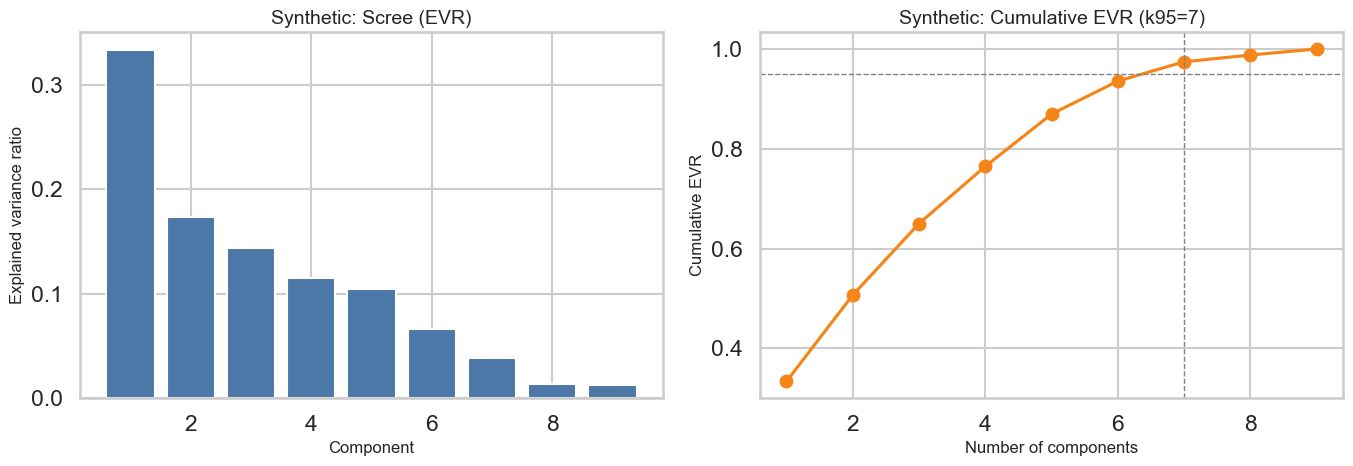

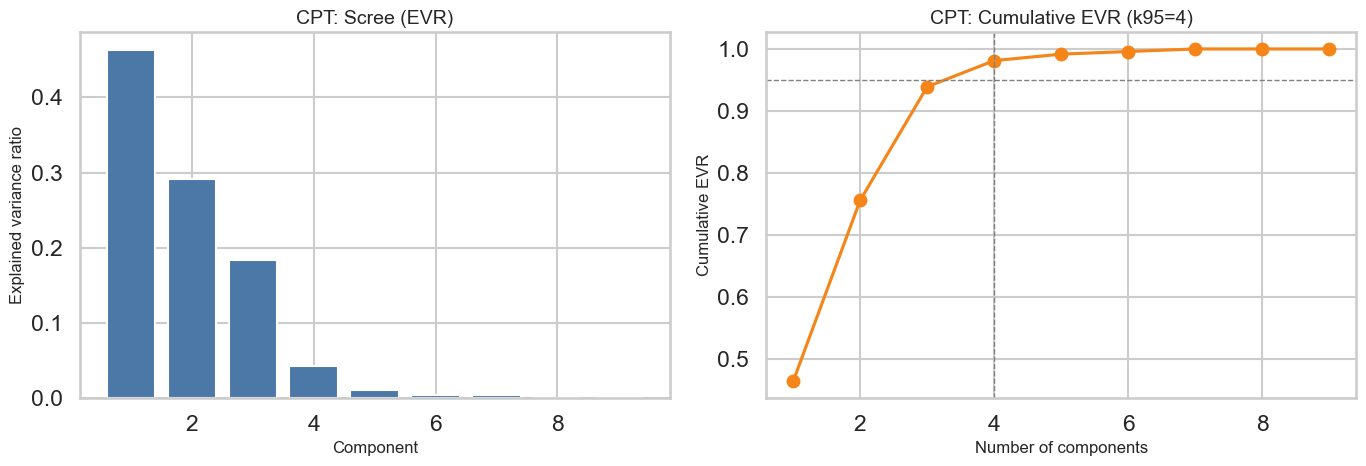

In [10]:
# Section 5: PCA scree plots (inline)
if Xs_syn is not None:
    pca_syn = PCA(n_components=None, random_state=SEED)
    pca_syn.fit(Xs_syn)
    evr = pca_syn.explained_variance_ratio_
    cum = np.cumsum(evr)
    k95 = np.argmax(cum >= 0.95) + 1 if np.any(cum >= 0.95) else len(evr)
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].bar(np.arange(1, len(evr) + 1), evr, color="#4C78A8")
    ax[0].set_title("Synthetic: Scree (EVR)")
    ax[0].set_xlabel("Component")
    ax[0].set_ylabel("Explained variance ratio")
    ax[1].plot(np.arange(1, len(cum) + 1), cum, marker="o", color="#F58518")
    ax[1].axhline(0.95, color="gray", linestyle="--", linewidth=1)
    ax[1].axvline(k95, color="gray", linestyle="--", linewidth=1)
    ax[1].set_title(f"Synthetic: Cumulative EVR (k95={k95})")
    ax[1].set_xlabel("Number of components")
    ax[1].set_ylabel("Cumulative EVR")
    plt.tight_layout()
    plt.show()
else:
    pca_syn = None

pca_eq = None
if Xs_eq is not None:
    pca_eq = PCA(n_components=None, random_state=SEED)
    pca_eq.fit(Xs_eq)
    evr_eq = pca_eq.explained_variance_ratio_
    cum_eq = np.cumsum(evr_eq)
    k95_eq = np.argmax(cum_eq >= 0.95) + 1 if np.any(cum_eq >= 0.95) else len(evr_eq)
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].bar(np.arange(1, len(evr_eq) + 1), evr_eq, color="#4C78A8")
    ax[0].set_title("Earthquakes: Scree (EVR)")
    ax[0].set_xlabel("Component")
    ax[0].set_ylabel("Explained variance ratio")
    ax[1].plot(np.arange(1, len(cum_eq) + 1), cum_eq, marker="o", color="#F58518")
    ax[1].axhline(0.95, color="gray", linestyle="--", linewidth=1)
    ax[1].axvline(k95_eq, color="gray", linestyle="--", linewidth=1)
    ax[1].set_title(f"Earthquakes: Cumulative EVR (k95={k95_eq})")
    ax[1].set_xlabel("Number of components")
    ax[1].set_ylabel("Cumulative EVR")
    plt.tight_layout()
    plt.show()
pca_cpt = None

if Xs_cpt is not None:
    pca_cpt = PCA(n_components=None, random_state=SEED)
    pca_cpt.fit(Xs_cpt)
    evr_cpt = pca_cpt.explained_variance_ratio_
    cum_cpt = np.cumsum(evr_cpt)
    k95_cpt = (
        np.argmax(cum_cpt >= 0.95) + 1 if np.any(cum_cpt >= 0.95) else len(evr_cpt)
    )
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].bar(np.arange(1, len(evr_cpt) + 1), evr_cpt, color="#4C78A8")
    ax[0].set_title("CPT: Scree (EVR)")
    ax[0].set_xlabel("Component")
    ax[0].set_ylabel("Explained variance ratio")
    ax[1].plot(np.arange(1, len(cum_cpt) + 1), cum_cpt, marker="o", color="#F58518")
    ax[1].axhline(0.95, color="gray", linestyle="--", linewidth=1)
    ax[1].axvline(k95_cpt, color="gray", linestyle="--", linewidth=1)
    ax[1].set_title(f"CPT: Cumulative EVR (k95={k95_cpt})")
    ax[1].set_xlabel("Number of components")
    ax[1].set_ylabel("Cumulative EVR")
    plt.tight_layout()
    plt.show()

## PCA: 2D projection and biplot



We'll visualize the first two principal components. For the synthetic dataset, we'll also add a biplot with feature loading vectors.

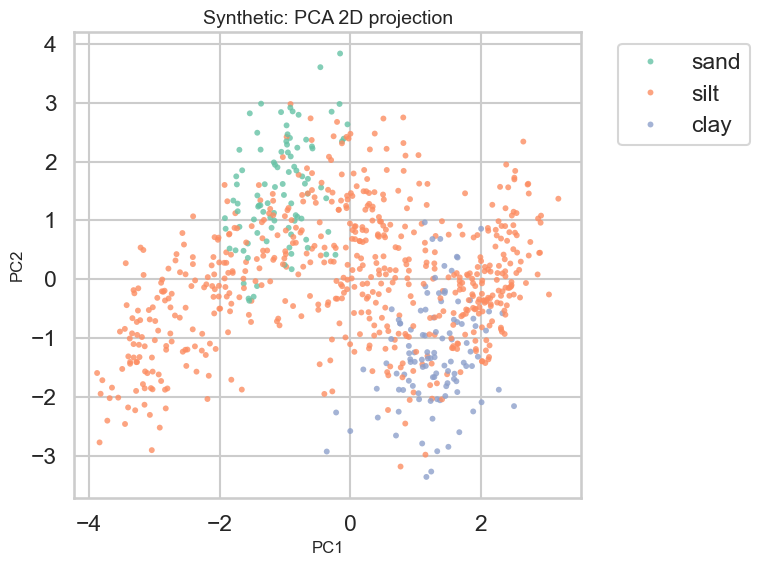

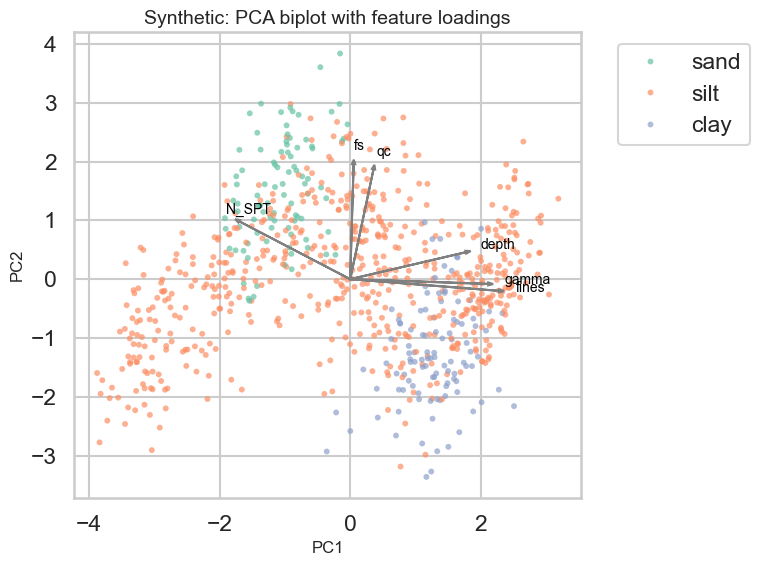

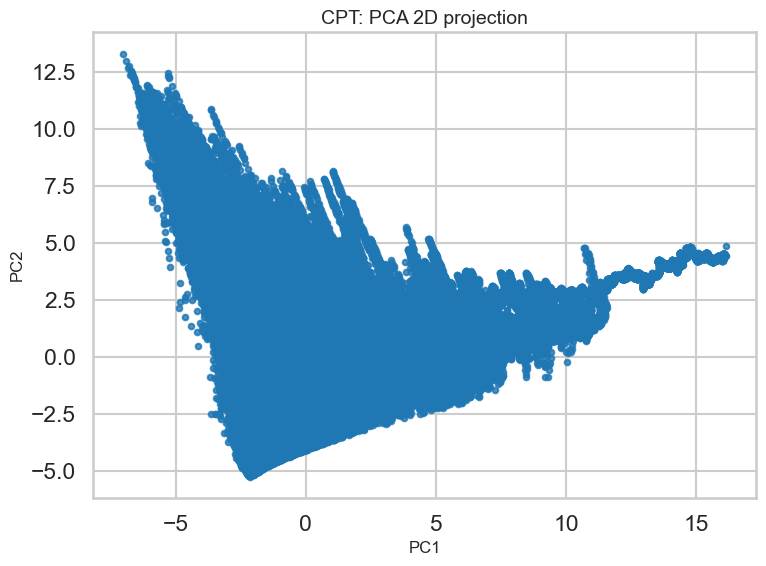

In [11]:
# Section 6: PCA 2D projection and biplot (inline)
labels_syn = (
    meta_syn["soil_type"]
    if meta_syn is not None and "soil_type" in meta_syn.columns
    else None
)
if Xs_syn is not None and pca_syn is not None:
    Z_syn_pca = pca_syn.transform(Xs_syn)[:, :2]
    plt.figure(figsize=(8, 6))
    if labels_syn is not None:
        sns.scatterplot(
            x=Z_syn_pca[:, 0],
            y=Z_syn_pca[:, 1],
            hue=labels_syn,
            palette="Set2",
            s=18,
            alpha=0.8,
            edgecolor="none",
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        plt.scatter(Z_syn_pca[:, 0], Z_syn_pca[:, 1], s=16, alpha=0.8)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Synthetic: PCA 2D projection")
    plt.tight_layout()
    plt.show()
    # Biplot (top features)
    comps = pca_syn.components_[:2, :]
    svals = np.sqrt(pca_syn.explained_variance_[:2])
    vecs = comps.T * svals
    norms = np.linalg.norm(vecs, axis=1)
    idx_top = np.argsort(norms)[-6:]
    plt.figure(figsize=(8, 6))
    if labels_syn is not None:
        sns.scatterplot(
            x=Z_syn_pca[:, 0],
            y=Z_syn_pca[:, 1],
            hue=labels_syn,
            palette="Set2",
            s=18,
            alpha=0.7,
            edgecolor="none",
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        plt.scatter(Z_syn_pca[:, 0], Z_syn_pca[:, 1], s=16, alpha=0.7)
    for i in idx_top:
        v = vecs[i] * 2.5
        plt.arrow(
            0, 0, v[0], v[1], color="gray", head_width=0.05, length_includes_head=True
        )
        plt.text(v[0] * 1.08, v[1] * 1.08, feat_syn[i], fontsize=10, color="black")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Synthetic: PCA biplot with feature loadings")
    plt.tight_layout()
    plt.show()

# Earthquakes
labels_eq = None
if meta_eq is not None:
    for col in ["mag_bin", "depth_bin"]:
        if col in meta_eq.columns:
            labels_eq = meta_eq[col]
            break
if Xs_eq is not None and pca_eq is not None:
    Z_eq_pca = pca_eq.transform(Xs_eq)[:, :2]
    plt.figure(figsize=(8, 6))
    if labels_eq is not None:
        sns.scatterplot(
            x=Z_eq_pca[:, 0],
            y=Z_eq_pca[:, 1],
            hue=labels_eq,
            palette="Set2",
            s=18,
            alpha=0.8,
            edgecolor="none",
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        plt.scatter(Z_eq_pca[:, 0], Z_eq_pca[:, 1], s=16, alpha=0.8)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Earthquakes: PCA 2D projection")
    plt.tight_layout()
    plt.show()

# CPT
labels_cpt = None
if meta_cpt is not None:
    for col in ["qc_bin", "depth_bin"]:
        if col in meta_cpt.columns:
            labels_cpt = meta_cpt[col]
            break
if Xs_cpt is not None and pca_cpt is not None:
    Z_cpt_pca = pca_cpt.transform(Xs_cpt)[:, :2]
    plt.figure(figsize=(8, 6))
    if labels_cpt is not None:
        sns.scatterplot(
            x=Z_cpt_pca[:, 0],
            y=Z_cpt_pca[:, 1],
            hue=labels_cpt,
            palette="Set2",
            s=18,
            alpha=0.8,
            edgecolor="none",
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        plt.scatter(Z_cpt_pca[:, 0], Z_cpt_pca[:, 1], s=16, alpha=0.8)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("CPT: PCA 2D projection")
    plt.tight_layout()
    plt.show()

## PCA: Reconstruction error vs number of components



How many components are enough? We'll look at mean squared reconstruction error as we vary k.

In [12]:
# Section: CPT feature selection (SITE_INFO + FEATURES + LABELS_O) and numeric preprocessing
FEATURES = [
    "Depth (m)",
    "qc (MPa)",
    "fs (kPa)",
    "Rf (%)",
    "σ,v (kPa)",
    "u0 (kPa)",
    "σ',v (kPa)",
    "Qtn (-)",
    "Fr (%)",
]
SITE_INFO = ["ID", "test_type", "basin_valley"]
LABELS_O = ["Oberhollenzer_classes"]
Xs_cpt = None
feat_cpt = None
meta_cpt = None
labels_cpt = None
if df_cpt is not None:
    cols = SITE_INFO + FEATURES + LABELS_O
    available = [c for c in cols if c in df_cpt.columns]
    if not available:
        print("CPT: Requested columns not found; skipping strict selection.")
    else:
        df = df_cpt.loc[:, available].copy()
        site_cols = [c for c in SITE_INFO if c in df.columns]
        label_cols = [c for c in LABELS_O if c in df.columns]
        feature_cols = [c for c in FEATURES if c in df.columns]
        if not feature_cols:
            print("CPT: No FEATURES columns present after selection.")
            meta_cpt = df[site_cols + label_cols] if (site_cols or label_cols) else None
            labels_cpt = df[label_cols[0]] if label_cols else None
        else:
            num = df[feature_cols].select_dtypes(include=[np.number]).copy()
            nunique = num.nunique()
            num = num[nunique[nunique > 1].index.tolist()]
            q1 = num.quantile(0.01)
            q99 = num.quantile(0.99)
            num = num.clip(lower=q1, upper=q99, axis=1)
            imp_cpt = SimpleImputer(strategy="median")
            X_cpt = imp_cpt.fit_transform(num)
            scaler_cpt = StandardScaler()
            Xs_cpt = scaler_cpt.fit_transform(X_cpt)
            feat_cpt = num.columns.tolist()
            meta_cpt = df[site_cols + label_cols] if (site_cols or label_cols) else None
            labels_cpt = df[label_cols[0]] if label_cols else None
            print(
                "CPT features used:",
                len(feat_cpt),
                "Site/meta columns:",
                len(site_cols) + len(label_cols),
            )

CPT features used: 9 Site/meta columns: 4


## UMAP: 2D embeddings and quick visualization



UMAP aims to preserve local neighborhood structure in a low-dimensional embedding. We'll compare it to PCA visually.

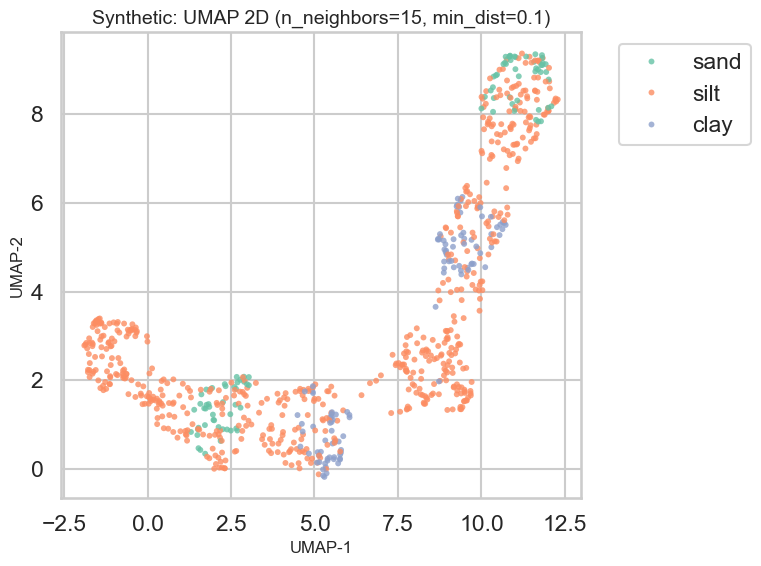

In [13]:
# Section 8: UMAP quick visualization (inline)
Z_syn_umap = None
if Xs_syn is not None:
    reducer_syn = UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="euclidean",
        random_state=SEED,
    )
    Z_syn_umap = reducer_syn.fit_transform(Xs_syn)
    plt.figure(figsize=(8, 6))
    if labels_syn is not None:
        sns.scatterplot(
            x=Z_syn_umap[:, 0],
            y=Z_syn_umap[:, 1],
            hue=labels_syn,
            palette="Set2",
            s=18,
            alpha=0.8,
            edgecolor="none",
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        plt.scatter(Z_syn_umap[:, 0], Z_syn_umap[:, 1], s=16, alpha=0.8)
    plt.title("Synthetic: UMAP 2D (n_neighbors=15, min_dist=0.1)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()

In [14]:
Z_eq_umap = None
if Xs_eq is not None:
    reducer_eq = UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="euclidean",
        random_state=SEED,
    )
    Z_eq_umap = reducer_eq.fit_transform(Xs_eq)
    plt.figure(figsize=(8, 6))
    if labels_eq is not None:
        sns.scatterplot(
            x=Z_eq_umap[:, 0],
            y=Z_eq_umap[:, 1],
            hue=labels_eq,
            palette="Set2",
            s=18,
            alpha=0.8,
            edgecolor="none",
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        plt.scatter(Z_eq_umap[:, 0], Z_eq_umap[:, 1], s=16, alpha=0.8)
    plt.title("Earthquakes: UMAP 2D (n_neighbors=15, min_dist=0.1)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()

In [15]:
Z_cpt_umap = None
if Xs_cpt is not None:
    reducer_cpt = UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="euclidean",
        random_state=SEED,
    )
    Z_cpt_umap = reducer_cpt.fit_transform(Xs_cpt)
    plt.figure(figsize=(8, 6))
    if labels_cpt is not None:
        sns.scatterplot(
            x=Z_cpt_umap[:, 0],
            y=Z_cpt_umap[:, 1],
            hue=labels_cpt,
            palette="Set2",
            s=18,
            alpha=0.8,
            edgecolor="none",
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        plt.scatter(Z_cpt_umap[:, 0], Z_cpt_umap[:, 1], s=16, alpha=0.8)
    plt.title("CPT: UMAP 2D (n_neighbors=15, min_dist=0.1)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

## UMAP parameter sweep and trustworthiness



We'll see how `n_neighbors` and `min_dist` affect the embedding. If available, we'll compute trustworthiness to quantify neighborhood preservation.

In [ ]:
# Section 9: Parameter sweep (inline)
if Xs_syn is not None:
    nn_list = [5, 15, 50]
    md_list = [0.0, 0.3, 0.8]
    nrows, ncols = len(nn_list), len(md_list)
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(4 * ncols + 2, 3.5 * nrows + 1), squeeze=False
    )
    for i, nn in enumerate(nn_list):
        for j, md in enumerate(md_list):
            reducer = UMAP(
                n_components=2, n_neighbors=nn, min_dist=md, random_state=SEED
            )
            Z = reducer.fit_transform(Xs_syn)
            ax = axes[i, j]
            if labels_syn is not None:
                sns.scatterplot(
                    x=Z[:, 0],
                    y=Z[:, 1],
                    hue=labels_syn,
                    palette="Set2",
                    s=10,
                    alpha=0.8,
                    edgecolor="none",
                    ax=ax,
                    legend=False,
                )
            else:
                ax.scatter(Z[:, 0], Z[:, 1], s=10, alpha=0.8)
            title = f"n_neighbors={nn}, min_dist={md}"
            if trustworthiness is not None:
                try:
                    tw = trustworthiness(Xs_syn, Z, n_neighbors=10)
                    title += f"\ntrustworthiness@10={tw:.3f}"
                except Exception:  # noqa: BLE001
                    pass
            ax.set_title(title)
            ax.set_xlabel("UMAP-1")
            ax.set_ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()

## Compare PCA vs UMAP: neighborhood preservation and clustering separability



We'll compute trustworthiness (if available) and silhouette scores after KMeans on the 2D embeddings.

In [ ]:
# Section 10: Compare PCA vs UMAP quantitatively on synthetic (inline minimal)
if Xs_syn is not None:
    pca2 = PCA(n_components=2, random_state=SEED)
    Zp = pca2.fit_transform(Xs_syn)
    reducer = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=SEED)
    Zu = reducer.fit_transform(Xs_syn)
    tw_p = (
        trustworthiness(Xs_syn, Zp, n_neighbors=10)
        if trustworthiness is not None
        else np.nan
    )
    tw_u = (
        trustworthiness(Xs_syn, Zu, n_neighbors=10)
        if trustworthiness is not None
        else np.nan
    )
    ks = range(2, 7)
    sil_p, sil_u = [], []
    for k in ks:
        km = KMeans(n_clusters=k, random_state=SEED, n_init="auto")
        sil_p.append(silhouette_score(Zp, km.fit_predict(Zp)))
        sil_u.append(silhouette_score(Zu, km.fit_predict(Zu)))
    width = 0.35
    x = np.arange(len(list(ks)))
    plt.figure(figsize=(8, 5))
    plt.bar(x - width / 2, sil_p, width=width, label=f"PCA2 (tw={tw_p:.3f})")
    plt.bar(x + width / 2, sil_u, width=width, label=f"UMAP2 (tw={tw_u:.3f})")
    plt.xticks(x, [str(k) for k in ks])
    plt.xlabel("KMeans clusters (k)")
    plt.ylabel("Silhouette score")
    plt.title("Synthetic: Clustering separability on 2D embeddings")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Apply workflow to Earthquake dataset (if present)



We'll automatically select numeric columns, create magnitude/depth bins if available, scale, and run PCA and UMAP.

In [ ]:
# Section 11: PCA 2D projection & biplot (synthetic), then earthquakes/CPT (inline)
if Xs_syn is not None:
    p_syn = PCA(n_components=2, random_state=SEED)
    Z2_syn = p_syn.fit_transform(Xs_syn)
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=Z2_syn[:, 0],
        y=Z2_syn[:, 1],
        hue=labels_syn,
        palette="tab10",
        s=20,
        alpha=0.8,
        legend=False,
    )
    plt.title("Synthetic: PCA 2D projection")
    plt.tight_layout()
    plt.show()
    # Rudimentary biplot using top loadings
    comps = p_syn.components_
    pc1_load = np.abs(comps[0])
    top_idx = pc1_load.argsort()[::-1][:5]
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=Z2_syn[:, 0],
        y=Z2_syn[:, 1],
        hue=labels_syn,
        palette="tab10",
        s=15,
        alpha=0.8,
        legend=False,
    )
    for i in top_idx:
        plt.arrow(
            0,
            0,
            comps[0, i] * 5,
            comps[1, i] * 5,
            color="red",
            alpha=0.6,
            head_width=0.1,
        )
        plt.text(
            comps[0, i] * 5 * 1.1,
            comps[1, i] * 5 * 1.1,
            f"f{i}",
            color="red",
            fontsize=9,
        )
    plt.title("Synthetic: PCA biplot (top loadings)")
    plt.tight_layout()
    plt.show()
# Earthquakes PCA projection (if available)
if Xs_eq is not None:
    p_eq = PCA(n_components=10, random_state=SEED)
    p_eq.fit(Xs_eq)
    # Inline scree/cumulative EVR
    evr = p_eq.explained_variance_ratio_
    cum = np.cumsum(evr)
    k95 = int(np.argmax(cum >= 0.95)) + 1
    fig, axs = plt.subplots(1, 2, figsize=(11, 4))
    axs[0].plot(np.arange(1, len(evr) + 1), evr, marker="o")
    axs[0].set_title("Earthquakes: PCA Scree")
    axs[0].set_xlabel("PC")
    axs[0].set_ylabel("Explained variance ratio")
    axs[1].plot(np.arange(1, len(cum) + 1), cum, marker="o")
    axs[1].axhline(0.95, color="red", linestyle="--")
    axs[1].axvline(k95, color="red", linestyle="--")
    axs[1].set_title("Earthquakes: PCA cumulative EVR")
    axs[1].set_xlabel("PC")
    axs[1].set_ylabel("Cumulative EVR")
    fig.suptitle("PCA Scree & Cumulative (Earthquakes)")
    fig.tight_layout()
    plt.show()
    p2 = PCA(n_components=2, random_state=SEED)
    Z2_eq = p2.fit_transform(Xs_eq)
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=Z2_eq[:, 0], y=Z2_eq[:, 1], s=15, alpha=0.8)
    plt.title("Earthquakes: PCA 2D projection")
    plt.tight_layout()
    plt.show()
# CPT PCA projection (if available)
if Xs_cpt is not None:
    p_cpt = PCA(n_components=10, random_state=SEED)
    p_cpt.fit(Xs_cpt)
    # Inline scree/cumulative EVR
    evr = p_cpt.explained_variance_ratio_
    cum = np.cumsum(evr)
    k95 = int(np.argmax(cum >= 0.95)) + 1
    fig, axs = plt.subplots(1, 2, figsize=(11, 4))
    axs[0].plot(np.arange(1, len(evr) + 1), evr, marker="o")
    axs[0].set_title("CPT: PCA Scree")
    axs[0].set_xlabel("PC")
    axs[0].set_ylabel("Explained variance ratio")
    axs[1].plot(np.arange(1, len(cum) + 1), cum, marker="o")
    axs[1].axhline(0.95, color="red", linestyle="--")
    axs[1].axvline(k95, color="red", linestyle="--")
    axs[1].set_title("CPT: PCA cumulative EVR")
    axs[1].set_xlabel("PC")
    axs[1].set_ylabel("Cumulative EVR")
    fig.suptitle("PCA Scree & Cumulative (CPT)")
    fig.tight_layout()
    plt.show()
    p2 = PCA(n_components=2, random_state=SEED)
    Z2_cpt = p2.fit_transform(Xs_cpt)
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=Z2_cpt[:, 0], y=Z2_cpt[:, 1], s=15, alpha=0.8)
    plt.title("CPT: PCA 2D projection")
    plt.tight_layout()
    plt.show()

## Apply workflow to CPT dataset CPT_PremstallerGeotechnik_revised.csv (if present)



We'll prefer typical CPT features if available, create simple coloring by qc or depth bins, then scale and embed. We'll also list top PCA loadings to interpret influential variables.

In [ ]:
# Section 12: CPT dataset workflow
if Xs_cpt is not None and feat_cpt is not None:
    pca_cpt2 = PCA(n_components=2, random_state=SEED).fit(Xs_cpt)
    Zp_cpt = pca_cpt2.transform(Xs_cpt)
    Zu_cpt = UMAP(
        n_components=2, n_neighbors=15, min_dist=0.1, random_state=SEED
    ).fit_transform(Xs_cpt)
    # Labels already prepared earlier if available
    labels_cpt = None
    if meta_cpt is not None:
        for col in ["qc_bin", "depth_bin"]:
            if col in meta_cpt.columns:
                labels_cpt = meta_cpt[col]
                break
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    if labels_cpt is not None:
        sns.scatterplot(
            x=Zp_cpt[:, 0],
            y=Zp_cpt[:, 1],
            hue=labels_cpt,
            palette="Set2",
            s=12,
            alpha=0.8,
            edgecolor="none",
            ax=ax[0],
        )
        ax[0].legend().remove()
        sns.scatterplot(
            x=Zu_cpt[:, 0],
            y=Zu_cpt[:, 1],
            hue=labels_cpt,
            palette="Set2",
            s=12,
            alpha=0.8,
            edgecolor="none",
            ax=ax[1],
        )
        ax[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        ax[0].scatter(Zp_cpt[:, 0], Zp_cpt[:, 1], s=12, alpha=0.8)
        ax[1].scatter(Zu_cpt[:, 0], Zu_cpt[:, 1], s=12, alpha=0.8)
    ax[0].set_title("CPT: PCA(2)")
    ax[1].set_title("CPT: UMAP(2)")
    plt.tight_layout()
    plt.show()
    # Top PCA loadings
    pca_full = PCA(n_components=None, random_state=SEED).fit(Xs_cpt)
    comp1 = (
        pd.Series(pca_full.components_[0], index=feat_cpt)
        .abs()
        .sort_values(ascending=False)
        .head(10)
    )
    print("Top PCA-1 absolute loadings (CPT):")
    display(comp1)
else:
    print("CPT dataset not available or insufficient numeric features — skipped.")

## Optional: persist embeddings and figures



We can persist the 2D embeddings and save figures for later use in reports or slides.

In [ ]:
# Section 13: Persist optional artifacts
def save_embedding(Z, labels, name: str):
    if Z is None:
        return
    dfz = pd.DataFrame({"x": Z[:, 0], "y": Z[:, 1]})
    if labels is not None:
        dfz["label"] = labels.values if hasattr(labels, "values") else labels
    out = DATA_PROCESSED / f"embedding_{name}.csv"
    dfz.to_csv(out, index=False)
    print("Saved:", out)


save_embedding(Z_syn_umap, labels_syn, name="synthetic_umap2")
save_embedding(Z_eq_umap, labels_eq, name="earthquakes_umap2")
save_embedding(Z_cpt_umap, labels_cpt, name="cpt_umap2")

## 🧪 Student Task: Explore and Compare PCA vs UMAP

Use the cells below to run your own experiments:

- Try different UMAP settings (n_neighbors, min_dist, metric). What changes do you observe?
- Compute trustworthiness (if available) and silhouette on the 2D embeddings and compare to PCA.
- Inspect PCA loadings: which features drive PC1/PC2? Do they make geotechnical sense?
- Repeat on one of the real datasets (earthquake or CPT) if available.
- Optional: save your best embeddings to `data/model_ready/` or `notebooks/figures/` with a meaningful name.

Tip: Keep the random state fixed for fair comparison, and comment on stability and interpretability.

In [ ]:
# Starter code: Experiment with UMAP and PCA
# Select dataset: choose from Xs_syn, Xs_eq, Xs_cpt (some may be None)
X_use = Xs_syn if Xs_syn is not None else (Xs_eq if Xs_eq is not None else Xs_cpt)
labels_use = (
    labels_syn
    if Xs_syn is not None
    else (labels_eq if Xs_eq is not None else labels_cpt)
)
dataset_name = (
    "synthetic"
    if Xs_syn is not None
    else ("earthquake" if Xs_eq is not None else "cpt")
)
assert X_use is not None, (
    "No dataset available. Run earlier cells to prepare Xs_* variables."
)
# 1) PCA baseline
pca2 = PCA(n_components=2, random_state=SEED)
Zp = pca2.fit_transform(X_use)
# 2) UMAP: tweak these parameters
n_neighbors = 15
min_dist = 0.1
metric = "euclidean"  # try: 'manhattan', 'cosine', 'correlation'
reducer = UMAP(
    n_components=2,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
    random_state=SEED,
)
Zu = reducer.fit_transform(X_use)
# 3) Quantitative comparison
if trustworthiness is not None:
    tw_p = trustworthiness(X_use, Zp, n_neighbors=10)
    tw_u = trustworthiness(X_use, Zu, n_neighbors=10)
else:
    tw_p = np.nan
    tw_u = np.nan
km = KMeans(n_clusters=4, random_state=SEED, n_init="auto")
sil_p = silhouette_score(Zp, km.fit_predict(Zp))
sil_u = silhouette_score(Zu, km.fit_predict(Zu))
print(f"Dataset: {dataset_name}")
print(f"Trustworthiness — PCA: {tw_p:.3f}, UMAP: {tw_u:.3f}")
print(f"Silhouette — PCA: {sil_p:.3f}, UMAP: {sil_u:.3f}")
# 4) Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(
    x=Zp[:, 0],
    y=Zp[:, 1],
    hue=labels_use,
    palette="tab10",
    s=15,
    alpha=0.8,
    ax=axes[0],
    legend=False,
)
axes[0].set_title("PCA (2D)")
sns.scatterplot(
    x=Zu[:, 0],
    y=Zu[:, 1],
    hue=labels_use,
    palette="tab10",
    s=15,
    alpha=0.8,
    ax=axes[1],
    legend=False,
)
axes[1].set_title(f"UMAP (2D) — k={n_neighbors}, min_dist={min_dist}, metric={metric}")
plt.tight_layout()
plt.show()
# 5) Optional: Inspect PCA loadings
loadings = pd.Series(
    np.abs(pca2.components_[0]), index=[f"f{i}" for i in range(Zp.shape[1])]
)
print("Top 5 features driving PC1 (index-based names):")
print(loadings.sort_values(ascending=False).head(5))
# 6) Optional: Save embeddings
# out = pd.DataFrame({"pca1": Zp[:, 0], "pca2": Zp[:, 1], "umap1": Zu[:, 0], "umap2": Zu[:, 1], "label": labels_use})
# out.to_csv(Path(DATA_DIR, f"embedding_{dataset_name}_student.csv"), index=False)